In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

import sklearn.metrics.pairwise as dis_lib

data_df = pd.read_csv("dataset_exercise_5_clustering_highway_traffic.csv",sep=";")

In [2]:
####################### Vectorise data #########################

# Sort the DataFrame 'data_df' by columns "Date" and "Interval_5"
data_df.sort_values(["Date", "Interval_5"])

# Extract unique dates from the sorted DataFrame
days = np.unique(data_df[['Date']].values.ravel())
# Calculate the total number of unique days
ndays = len(days)

# Group the DataFrame 'data_df' by the "Date" column
day_subsets_df = data_df.groupby(["Date"])

# Define the total number of 5-minute intervals in a day
nintvals = 288

# Create a matrix 'vectorized_day_dataset' filled with NaN values
vectorized_day_dataset = np.zeros((ndays, nintvals))
vectorized_day_dataset.fill(np.nan)

# Loop through each unique day
for i in range(0, ndays):
    # Get the DataFrame corresponding to the current day
    df_t = day_subsets_df.get_group(days[i])

    # Loop through each row in the current day's DataFrame
    for j in range(len(df_t)):

        # Extract the "Interval_5" and "flow" values and populate 'vectorized_day_dataset'
        vectorized_day_dataset[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]


In [3]:
####################### evaluation function #########################

# Define a function to find the closest centroid to a new data point within a specified day-time interval range
def find_the_closest_centroid(centroids, new_day, from_interval: int, to_interval: int):
    closest_centroid = None
    closest_dist = None

    # Iterate through each centroid
    for i in range(0, len(centroids)):
        # Calculate the Euclidean distance between the centroid and the new data point
        ed_t = dis_lib.paired_distances(centroids[i], new_day, metric='euclidean')

        # Check if the current centroid is closer than the previously closest one
        if closest_centroid is None or closest_dist > ed_t:
            closest_centroid = i
            closest_dist = ed_t

    return closest_centroid

def evaluation(cluster_labels, n_clusters_t):
    # Read the evaluation dataset from a CSV file
    data_eval_df = pd.read_csv("evaluation_dataset_exercise_5_clustering_highway_traffic.csv", sep=";")
    
    # Sort the evaluation DataFrame by columns "Date" and "Interval_5"
    data_eval_df.sort_values(["Date", "Interval_5"])
    
    # Extract unique dates from the sorted evaluation DataFrame
    days_eval = np.unique(data_eval_df[['Date']].values.ravel())
    # Calculate the total number of unique days in the evaluation dataset
    ndays_eval = len(days_eval)
    
    # Group the evaluation DataFrame by the "Date" column
    day_eval_subsets_df = data_eval_df.groupby(["Date"])
    
    # Initialize a matrix 'vectorized_day_dataset_eval' filled with NaN values
    vectorized_day_dataset_eval = np.zeros((ndays_eval, nintvals))
    vectorized_day_dataset_eval.fill(np.nan)
    # This section initializes a 2D array to store the evaluation dataset and fills it with NaN values.
    
    # Loop through each unique day in the evaluation dataset
    for i in range(0, ndays_eval):
        # Get the DataFrame corresponding to the current day
        df_t = day_eval_subsets_df.get_group(days_eval[i])
    
        # Loop through each row in the current day's DataFrame
        for j in range(len(df_t)):
            # Get the current day's DataFrame (this line is redundant)
            df_t = day_eval_subsets_df.get_group(days_eval[i])
    
            # Extract the "Interval_5" and "flow" values and populate 'vectorized_day_dataset_eval'
            vectorized_day_dataset_eval[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]
    
    # Calculate the number of days with missing values
    nans_per_day_eval = np.sum(np.isnan(vectorized_day_dataset_eval), 1)
    
    # Filter out days with no missing values and create a new dataset
    vectorized_day_dataset_no_nans_eval = vectorized_day_dataset_eval[np.where(nans_per_day_eval == 0)[0], :]
    days_not_nans_eval = days_eval[np.where(nans_per_day_eval == 0)[0]]
    
    # Calculate the total number of days in the filtered evaluation dataset
    ndays_eval_not_nans = len(days_not_nans_eval)
    
    # Initialize a list to store centroid data
    centroids = []
    
    # Calculate centroids for each cluster
    for i in range(0, n_clusters_t):
        centroid = np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).reshape(1, nintvals)
        centroids.append(centroid)
        
    # Define the number of past intervals to consider for classification
    n_past_intervals_for_classification = 5
    
    # Initialize variables to calculate accuracy metrics
    total_mae = 0
    total_mape = 0
    prediction_counts = 0
    
    # Loop through each day in the evaluation dataset with no missing values
    for i in range(0, ndays_eval_not_nans):
        # Loop through intervals from n_past_intervals_for_classification to nintvals - 1
        for j in range(n_past_intervals_for_classification, nintvals - 1):
            # Find the closest centroid for the current data point
            centroid_index = find_the_closest_centroid(centroids, vectorized_day_dataset_no_nans_eval[i].reshape(1, nintvals), j - n_past_intervals_for_classification, j)
    
            # Predict the value for the next interval
            predicted_value = centroids[centroid_index][0, j + 1]
    
            # Calculate Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE)
            mae_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1])
            mape_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1]) / float(vectorized_day_dataset_no_nans_eval[i][j + 1])
    
            # Accumulate MAE, MAPE, and count of predictions
            total_mae += mae_t
            total_mape += mape_t
            prediction_counts += 1
    
    # Calculate and print the prediction accuracy metrics
    print('Prediction accuracy MAE:', total_mae / prediction_counts)
    print('Prediction accuracy MAPE:', total_mape / prediction_counts)

    # Read the evaluation dataset from a CSV file
    data_eval_df = pd.read_csv("evaluation_dataset_exercise_5_clustering_highway_traffic.csv", sep=";")
    
    # Sort the evaluation DataFrame by columns "Date" and "Interval_5"
    data_eval_df.sort_values(["Date", "Interval_5"])
    
    # Extract unique dates from the sorted evaluation DataFrame
    days_eval = np.unique(data_eval_df[['Date']].values.ravel())
    # Calculate the total number of unique days in the evaluation dataset
    ndays_eval = len(days_eval)
    
    # Group the evaluation DataFrame by the "Date" column
    day_eval_subsets_df = data_eval_df.groupby(["Date"])
    
    # Initialize a matrix 'vectorized_day_dataset_eval' filled with NaN values
    vectorized_day_dataset_eval = np.zeros((ndays_eval, nintvals))
    vectorized_day_dataset_eval.fill(np.nan)
    # This section initializes a 2D array to store the evaluation dataset and fills it with NaN values.
    
    # Loop through each unique day in the evaluation dataset
    for i in range(0, ndays_eval):
        # Get the DataFrame corresponding to the current day
        df_t = day_eval_subsets_df.get_group(days_eval[i])
    
        # Loop through each row in the current day's DataFrame
        for j in range(len(df_t)):
            # Get the current day's DataFrame (this line is redundant)
            df_t = day_eval_subsets_df.get_group(days_eval[i])
    
            # Extract the "Interval_5" and "flow" values and populate 'vectorized_day_dataset_eval'
            vectorized_day_dataset_eval[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]
    
    # Calculate the number of days with missing values
    nans_per_day_eval = np.sum(np.isnan(vectorized_day_dataset_eval), 1)
    
    # Filter out days with no missing values and create a new dataset
    vectorized_day_dataset_no_nans_eval = vectorized_day_dataset_eval[np.where(nans_per_day_eval == 0)[0], :]
    days_not_nans_eval = days_eval[np.where(nans_per_day_eval == 0)[0]]
    
    # Calculate the total number of days in the filtered evaluation dataset
    ndays_eval_not_nans = len(days_not_nans_eval)
    
    # Initialize a list to store centroid data
    centroids = []
    
    # Calculate centroids for each cluster
    for i in range(0, n_clusters_t):
        centroid = np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).reshape(1, nintvals)
        centroids.append(centroid)
        
    # Define the number of past intervals to consider for classification
    n_past_intervals_for_classification = 5
    
    # Initialize variables to calculate accuracy metrics
    total_mae = 0
    total_mape = 0
    prediction_counts = 0
    
    # Loop through each day in the evaluation dataset with no missing values
    for i in range(0, ndays_eval_not_nans):
        # Loop through intervals from n_past_intervals_for_classification to nintvals - 1
        for j in range(n_past_intervals_for_classification, nintvals - 1):
            # Find the closest centroid for the current data point
            centroid_index = find_the_closest_centroid(centroids, vectorized_day_dataset_no_nans_eval[i].reshape(1, nintvals), j - n_past_intervals_for_classification, j)
    
            # Predict the value for the next interval
            predicted_value = centroids[centroid_index][0, j + 1]
    
            # Calculate Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE)
            mae_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1])
            mape_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1]) / float(vectorized_day_dataset_no_nans_eval[i][j + 1])
    
            # Accumulate MAE, MAPE, and count of predictions
            total_mae += mae_t
            total_mape += mape_t
            prediction_counts += 1
    
    # Calculate and print the prediction accuracy metrics
    print('Prediction accuracy MAE:', total_mae / prediction_counts)
    print('Prediction accuracy MAPE:', total_mape / prediction_counts)

Clustering

kmeans parameter test

D:\Anacondas\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Anacondas\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Anacondas\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Anacondas\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

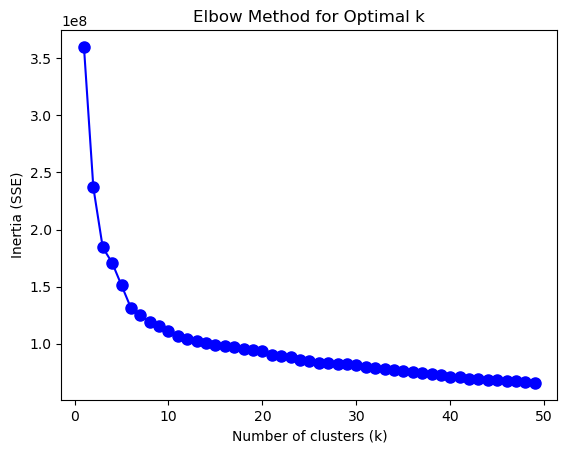

In [5]:
nans_per_day = np.sum(np.isnan(vectorized_day_dataset),1)
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]

inertia_values = []
k_range = range(1, 50)

for k in k_range:
    
    clusters = None
    days_not_nans = days[np.where(nans_per_day == 0)[0]]
    
    clusters = KMeans(n_clusters=k, 
                      random_state=0, 
                      n_init="auto").fit(vectorized_day_dataset_no_nans)
    
    inertia_values.append(clusters.inertia_)
    
plt.plot(k_range, inertia_values, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

kmeans evaluation

D:\Anacondas\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Prediction accuracy MAE: 25.32641523281189
Prediction accuracy MAPE: 0.25373071230363786
Prediction accuracy MAE: 25.32641523281189
Prediction accuracy MAPE: 0.25373071230363786
Silhouette Score: 0.24133229796735856
Davies-Bouldin Score: 1.4813566163658154
Calinski-Harabasz Score: 103.05063003488681


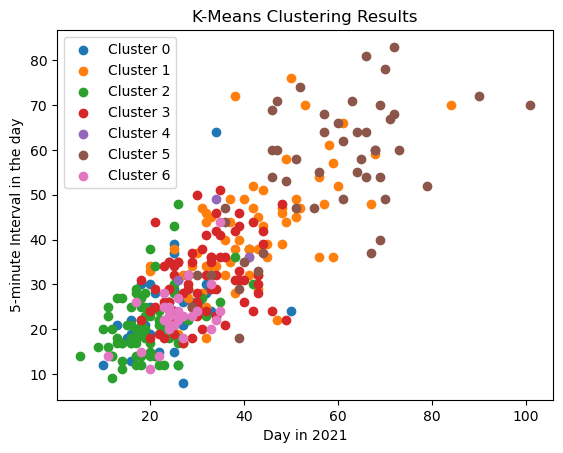

In [6]:
k = 7
clusters = KMeans(n_clusters=k, 
                  random_state=0, 
                  n_init="auto").fit(vectorized_day_dataset_no_nans)

cluster_labels_km = clusters.labels_

# Calculate the number of clusters by finding unique values in 'cluster_labels'
n_clusters_km = len(np.unique(cluster_labels_km)) 

evaluation(cluster_labels_km, n_clusters_km)

SC_score = silhouette_score(vectorized_day_dataset_no_nans, cluster_labels_km)
DB_score = davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels_km)
CH_score = calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels_km)
print('Silhouette Score:', SC_score)
print('Davies-Bouldin Score:', DB_score)
print('Calinski-Harabasz Score:', CH_score)

for i in range(k):
    plt.scatter(vectorized_day_dataset_no_nans[cluster_labels_km == i, 0],
                vectorized_day_dataset_no_nans[cluster_labels_km == i, 1],
                label=f'Cluster {i}')

plt.xlabel('Day in 2021')
plt.ylabel('5-minute Interval in the day')
plt.title('K-Means Clustering Results')
plt.legend()
plt.show()

dbscan parameter test

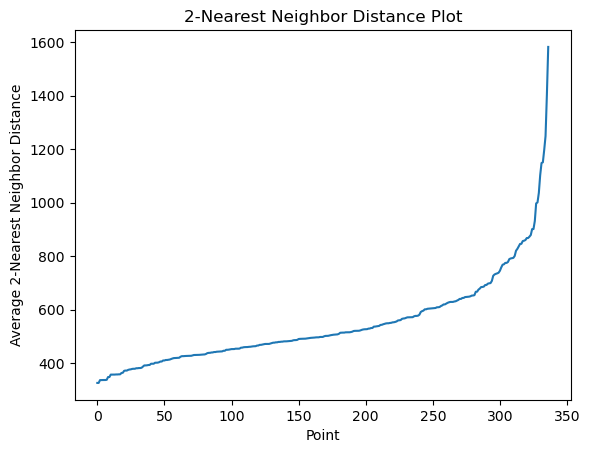

In [6]:
nans_per_day = np.sum(np.isnan(vectorized_day_dataset),1)
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]

from sklearn.neighbors import NearestNeighbors
dimension = len(vectorized_day_dataset_no_nans.shape)
min_samples = dimension + 1
k = min_samples - 1
nbrs = NearestNeighbors(n_neighbors=k).fit(vectorized_day_dataset_no_nans)
distances, indices = nbrs.kneighbors(vectorized_day_dataset_no_nans)
 
kth_distances = distances[:, k-1]

# Sort the distances in ascending order
sorted_kth_distances = sorted(kth_distances)

# Plot the sorted k-th nearest neighbor distances
plt.plot(sorted_kth_distances)
plt.xlabel('Point')
plt.ylabel(f'Average {k}-Nearest Neighbor Distance')
plt.title(f'{k}-Nearest Neighbor Distance Plot')
plt.show()

dbscan evaluation

Prediction accuracy MAE: 26.27921043835103
Prediction accuracy MAPE: 0.3578926968164425
Prediction accuracy MAE: 26.27921043835103
Prediction accuracy MAPE: 0.3578926968164425
Silhouette Score: -0.02772100330028316
Davies-Bouldin Score: 2.3795720914163097
Calinski-Harabasz Score: 35.327906331751436


C:\Users\10449\AppData\Local\Temp\ipykernel_23840\3460788858.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(vectorized_day_dataset_no_nans[cluster_labels_db == label, 0],


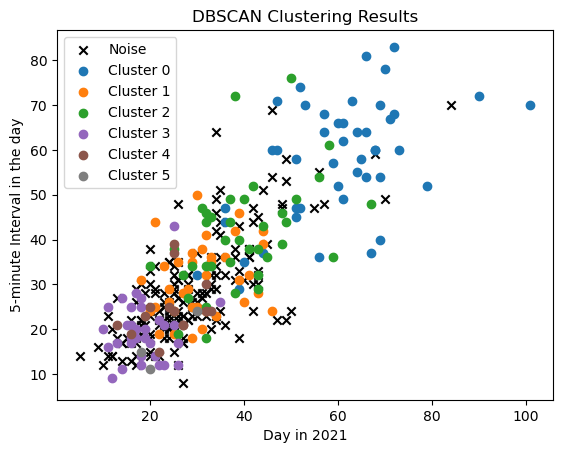

In [7]:
dbscan = DBSCAN(eps=500, min_samples=3)
cluster_labels_db = dbscan.fit_predict(vectorized_day_dataset_no_nans)
n_clusters_db = len(np.unique(cluster_labels_db)) - 1  # minus noise cluster

evaluation(cluster_labels_db, n_clusters_db)

SC_score = silhouette_score(vectorized_day_dataset_no_nans, cluster_labels_db)
DB_score = davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels_db)
CH_score = calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels_db)
print('Silhouette Score:', SC_score)
print('Davies-Bouldin Score:', DB_score)
print('Calinski-Harabasz Score:', CH_score)

unique_labels = np.unique(cluster_labels_db)
for label in unique_labels:
    if label == -1:
        # Noise points (label -1) are plotted in a different color
        color = 'k'
        marker = 'x'
    else:
        color = plt.cm.tab10(label / len(unique_labels))  # Use a colormap for different clusters
        marker = 'o'
    
    plt.scatter(vectorized_day_dataset_no_nans[cluster_labels_db == label, 0],
                vectorized_day_dataset_no_nans[cluster_labels_db == label, 1],
                c=color,
                marker=marker,
                label=f'Cluster {label}' if label != -1 else 'Noise')

plt.xlabel('Day in 2021')
plt.ylabel('5-minute Interval in the day')
plt.title('DBSCAN Clustering Results')
plt.legend()
plt.show()

AgglomerativeClustering parameter test

In [9]:
from sklearn.model_selection import GridSearchCV

def custom_bouldin_scorer(estimator, X):
    # Get the cluster labels using the estimator
    cluster_labels = estimator.fit_predict(X)
    
    # Return the silhouette score as the evaluation metric
    # Silhouette score requires at least 2 clusters
    if len(set(cluster_labels)) > 1:
        return davies_bouldin_score(X, cluster_labels)
    else:
        return -1  # Return -1 if all data points are assigned to one cluster

param_grid = {
    'n_clusters': [2, 3, 4, 5, 6, 7],
    'metric': ['euclidean', 'manhattan', 'cosine'],
    'linkage': ['complete', 'average', 'single']
}

# Grid search
grid_search = GridSearchCV(
    AgglomerativeClustering(),
    param_grid,
    scoring=custom_bouldin_scorer,
    cv=5
)
grid_search.fit(vectorized_day_dataset_no_nans)

print(f"Best parameters: {grid_search.best_params_}")
print("Best Score:", grid_search.best_score_)

Best parameters: {'linkage': 'complete', 'metric': 'manhattan', 'n_clusters': 7}
Best Score: 1.3914718028227748


AgglomerativeClustering evaluation

Prediction accuracy MAE: 27.005256483119897
Prediction accuracy MAPE: 0.263619883159103
Prediction accuracy MAE: 27.005256483119897
Prediction accuracy MAPE: 0.263619883159103
Silhouette Score: 0.21633980234935274
Davies-Bouldin Score: 1.285429991588437
Calinski-Harabasz Score: 81.4592508896327


C:\Users\10449\AppData\Local\Temp\ipykernel_14516\3126476170.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(vectorized_day_dataset_no_nans[cluster_labels_db == label, 0],


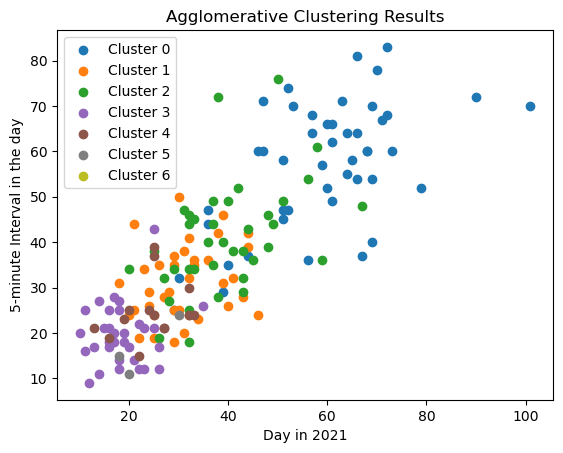

In [10]:
ag = AgglomerativeClustering(n_clusters=7,
                                   metric='manhattan', 
                                   linkage='complete').fit(vectorized_day_dataset_no_nans)

cluster_labels_ag = ag.fit_predict(vectorized_day_dataset_no_nans)
n_clusters_ag = len(np.unique(cluster_labels_ag))

evaluation(cluster_labels_ag, n_clusters_ag)

SC_score = silhouette_score(vectorized_day_dataset_no_nans, cluster_labels_ag)
DB_score = davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels_ag)
CH_score = calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels_ag)
print('Silhouette Score:', SC_score)
print('Davies-Bouldin Score:', DB_score)
print('Calinski-Harabasz Score:', CH_score)

unique_labels = np.unique(cluster_labels_ag)
for label in unique_labels:
    if label == -1:
        # Noise points (label -1) are plotted in a different color
        color = 'k'
        marker = 'x'
    else:
        color = plt.cm.tab10(label / len(unique_labels))  # Use a colormap for different clusters
        marker = 'o'
    
    plt.scatter(vectorized_day_dataset_no_nans[cluster_labels_db == label, 0],
                vectorized_day_dataset_no_nans[cluster_labels_db == label, 1],
                c=color,
                marker=marker,
                label=f'Cluster {label}' if label != -1 else 'Noise')

plt.xlabel('Day in 2021')
plt.ylabel('5-minute Interval in the day')
plt.title('Agglomerative Clustering Results')
plt.legend()
plt.show()